In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA # ARIMA model
from sklearn.metrics import mean_squared_error

In [2]:
airlines = pd.read_excel("C:/Users/SANJAY/Desktop/ExcelR/Assignments/Assignment - 18/Forecasting/Airlines+Data.xlsx")
airlines.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


# EDA

In [3]:
airlines.shape

(96, 2)

In [4]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [5]:
airlines.nunique()

Month         96
Passengers    80
dtype: int64

In [6]:
airlines.isna().sum()

Month         0
Passengers    0
dtype: int64

In [7]:
airlines.duplicated().value_counts()

False    96
dtype: int64

In [8]:
airlines.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,96.0,213.708333,71.918216,104.0,156.0,200.0,264.75,413.0


In [9]:
airlines.rename(columns = {'Month':'date','Passengers':'passengers'}, inplace = True)

In [10]:
# Changing index col to date
airlines.set_index('date',inplace=True)
airlines

,passengers
date,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


In [11]:
upsampled_month = airlines['passengers']
upsampled_month = upsampled_month.resample('M').mean()
pd.set_option('display.max_rows', 10)
upsampled_month
     

date
1995-01-31    112.0
1995-02-28    118.0
1995-03-31    132.0
1995-04-30    129.0
1995-05-31    121.0
              ...  
2002-08-31    405.0
2002-09-30    355.0
2002-10-31    306.0
2002-11-30    271.0
2002-12-31    306.0
Freq: M, Name: passengers, Length: 96, dtype: float64

In [12]:
interpolated_month = upsampled_month.interpolate(method='linear')
interpolated_month=pd.DataFrame(interpolated_month)
interpolated_month
     

,passengers
date,
1995-01-31,112.0
1995-02-28,118.0
1995-03-31,132.0
1995-04-30,129.0
1995-05-31,121.0
...,...
2002-08-31,405.0
2002-09-30,355.0
2002-10-31,306.0


In [13]:

interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.date.dt.strftime("%b") # month 
interpolated_month["year"] =pd.to_numeric( interpolated_month.date.dt.strftime("%Y")) # year

months = pd.get_dummies(interpolated_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
airlines_upsp = pd.concat([interpolated_month,months],axis=1)
airlines_upsp['log_passengers'] = np.log(airlines_upsp['passengers'])
airlines_upsp

,date,passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
0,1995-01-31,112.0,1,1,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,4.718499
1,1995-02-28,118.0,2,4,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,4.770685
2,1995-03-31,132.0,3,9,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0,4.882802
3,1995-04-30,129.0,4,16,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0,4.859812
4,1995-05-31,121.0,5,25,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-31,405.0,92,8464,Aug,2002,0,0,0,0,0,0,0,1,0,0,0,0,6.003887
92,2002-09-30,355.0,93,8649,Sep,2002,0,0,0,0,0,0,0,0,1,0,0,0,5.872118
93,2002-10-31,306.0,94,8836,Oct,2002,0,0,0,0,0,0,0,0,0,1,0,0,5.723585
94,2002-11-30,271.0,95,9025,Nov,2002,0,0,0,0,0,0,0,0,0,0,1,0,5.602119


In [14]:
airlines_upsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            96 non-null     datetime64[ns]
 1   passengers      96 non-null     float64       
 2   t               96 non-null     int32         
 3   t_squared       96 non-null     int32         
 4   month           96 non-null     object        
 5   year            96 non-null     int64         
 6   Jan             96 non-null     uint8         
 7   Feb             96 non-null     uint8         
 8   Mar             96 non-null     uint8         
 9   Apr             96 non-null     uint8         
 10  May             96 non-null     uint8         
 11  Jun             96 non-null     uint8         
 12  Jul             96 non-null     uint8         
 13  Aug             96 non-null     uint8         
 14  Sep             96 non-null     uint8         
 15  Oct     

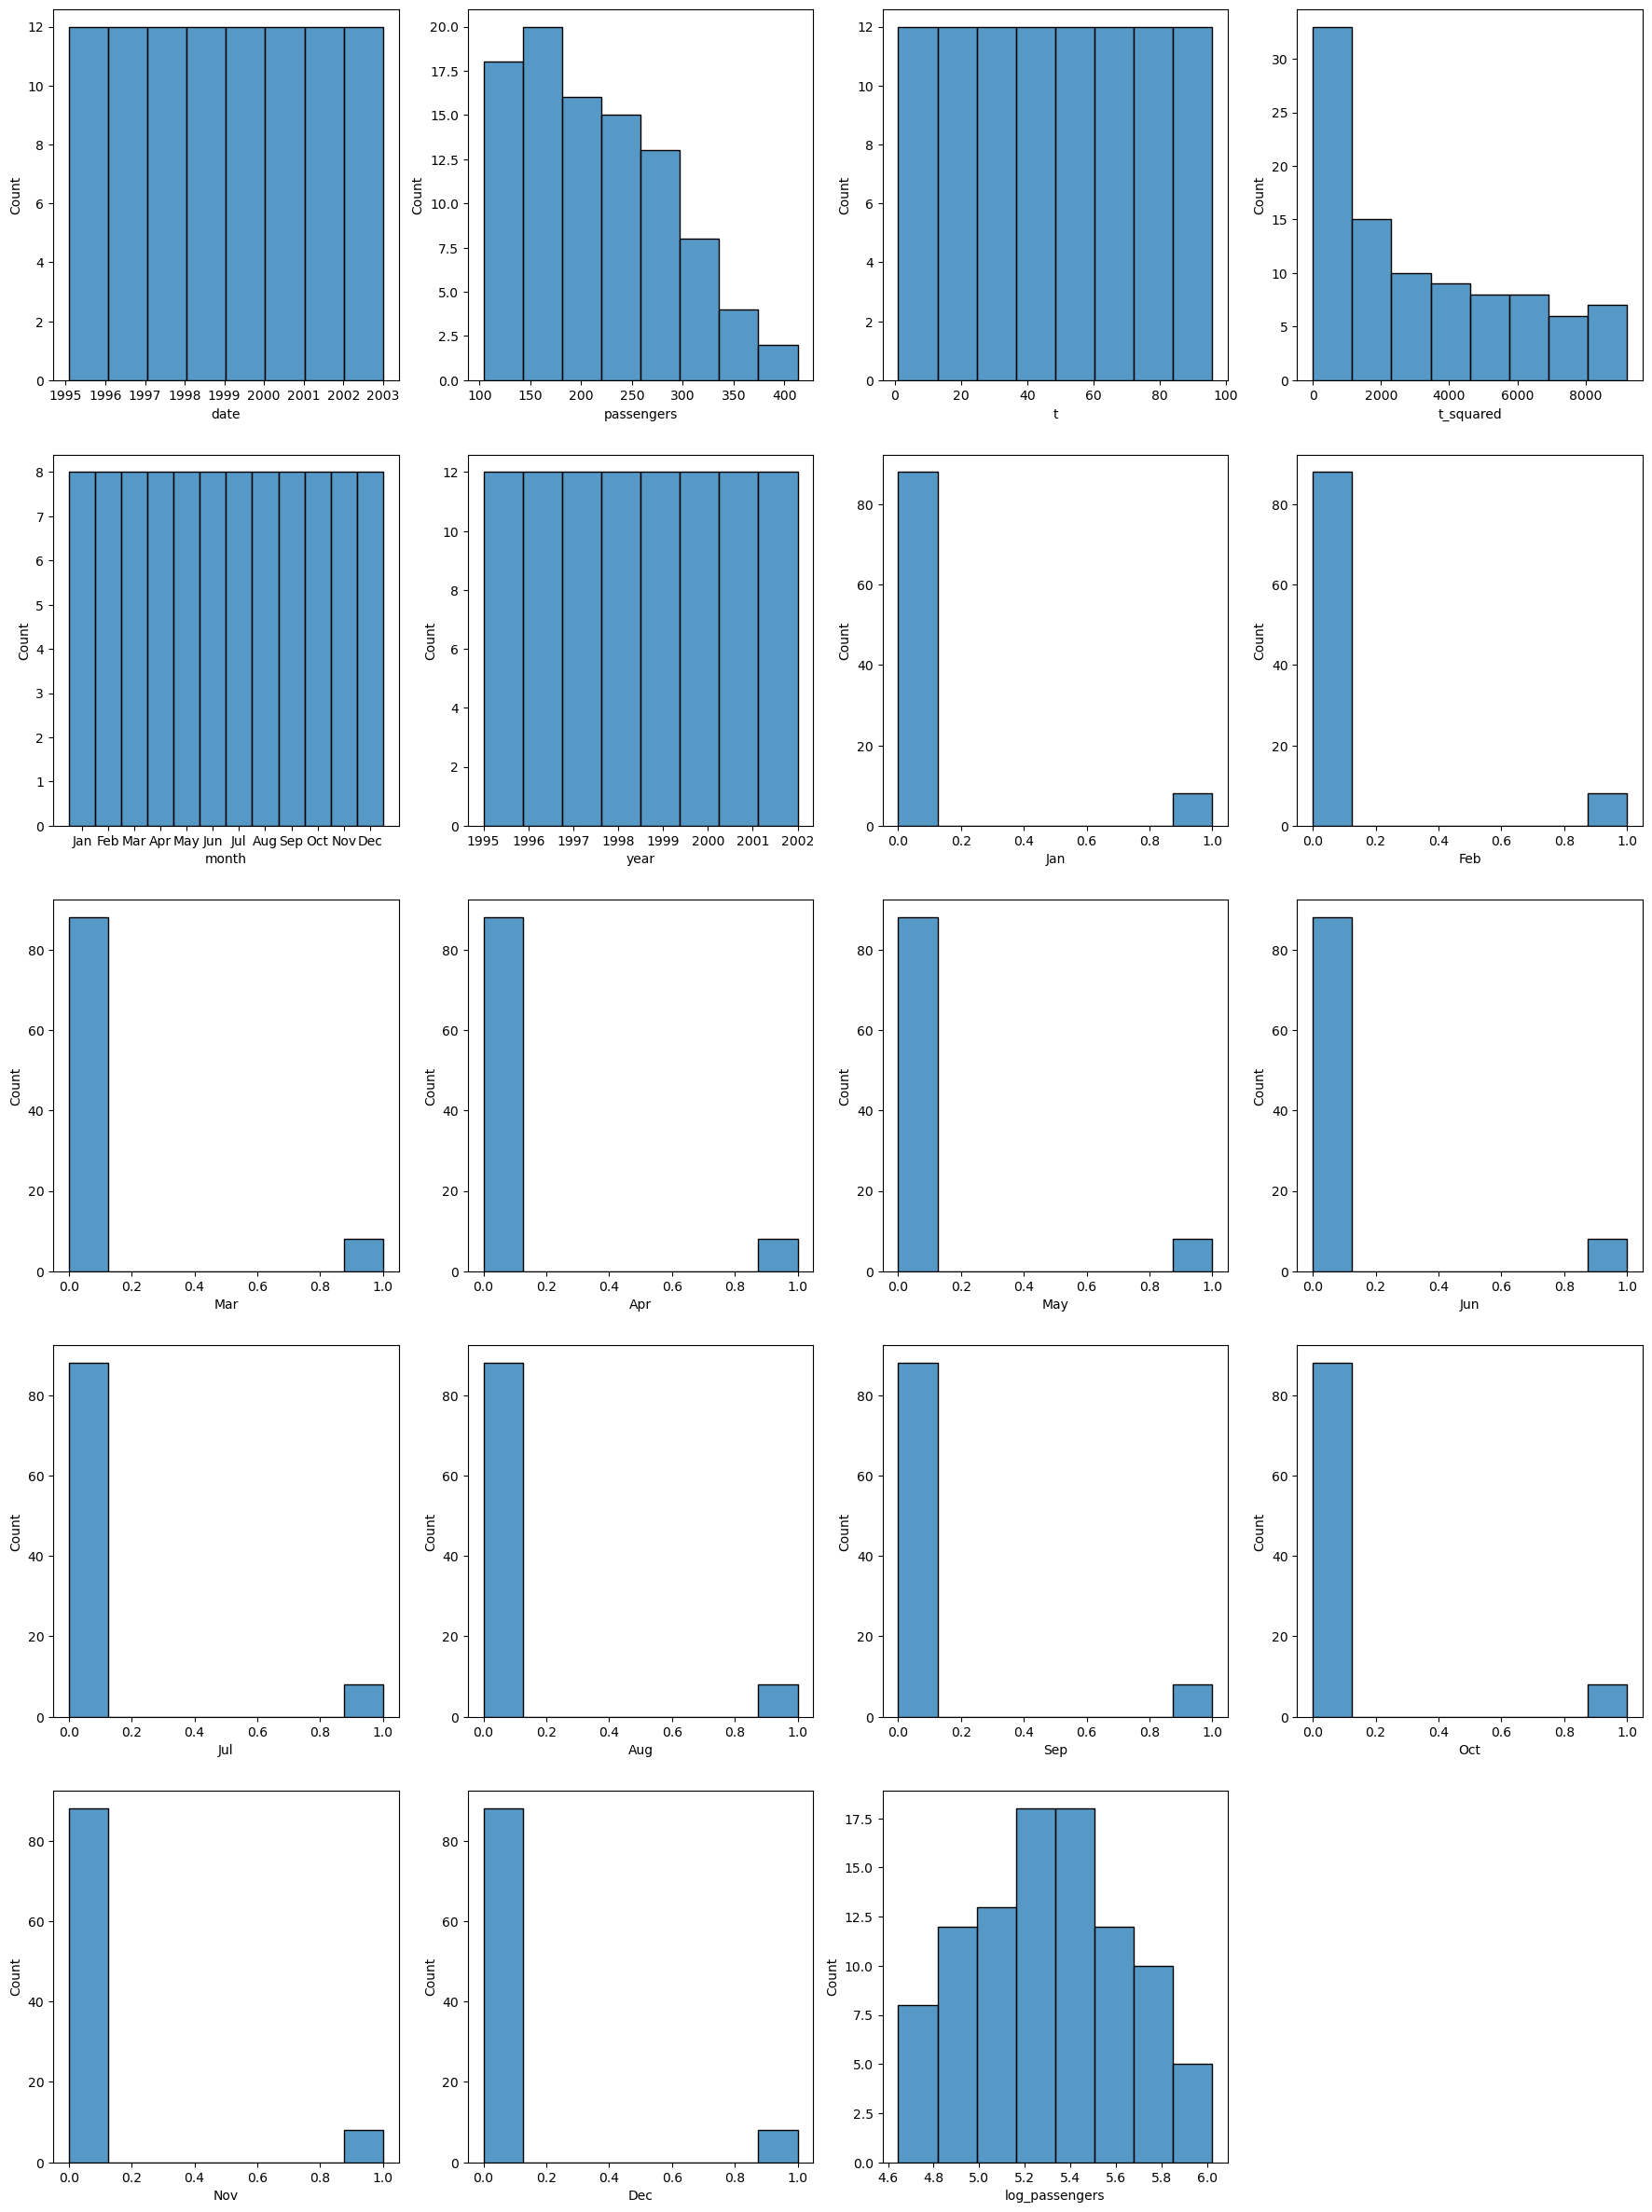

In [15]:
#plotting histplots to observe datapoints nature
plt.figure(figsize=(22,30))
for i, column in enumerate(airlines_upsp.columns, 1):
    plt.subplot(5,4,i)
    sns.histplot(airlines_upsp[column])

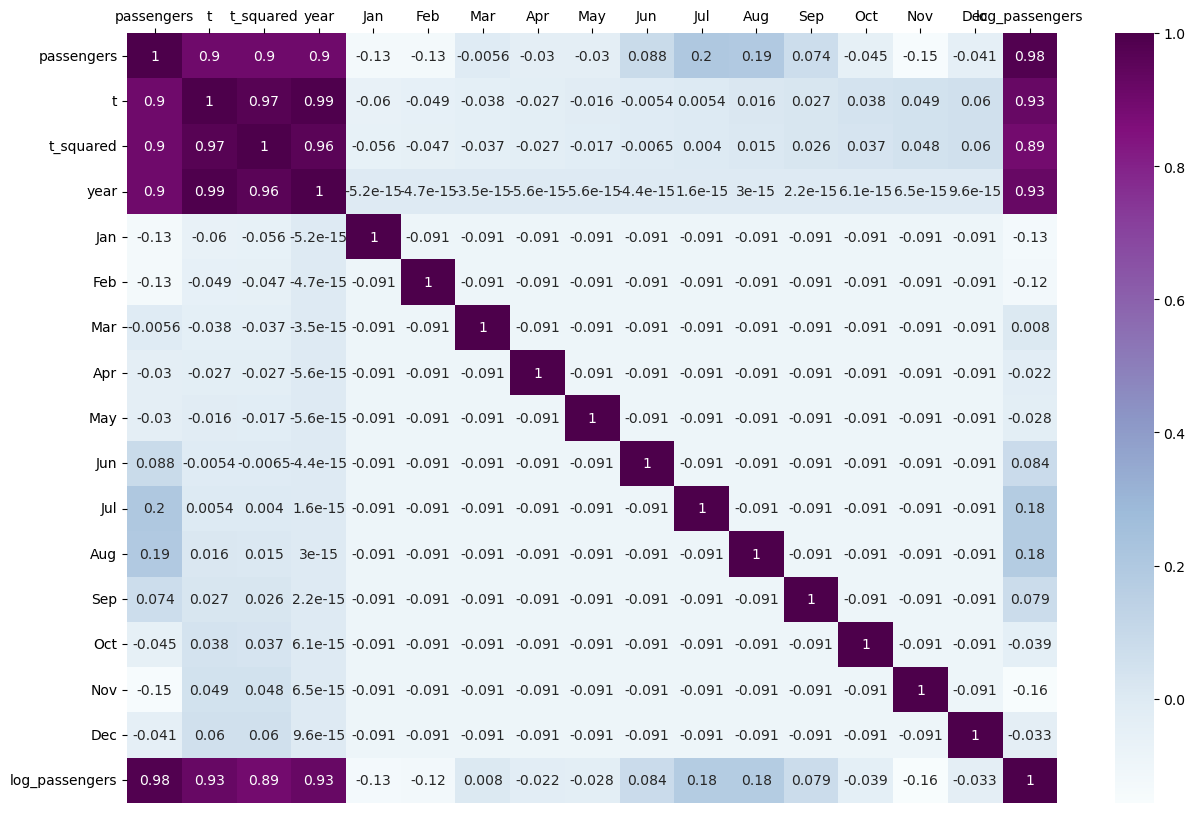

In [16]:
#plotting the heatmap for correlation
plt.figure(figsize=(15,10))
ax = sns.heatmap(airlines_upsp.corr(), annot=True,cmap='BuPu')
ax.xaxis.tick_top()

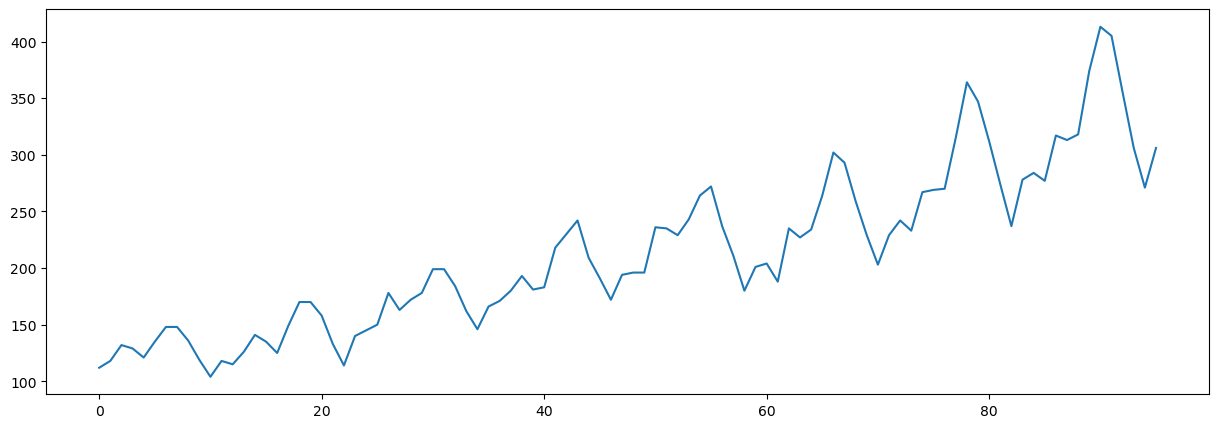

In [17]:
# Line plot
airlines_upsp['passengers'].plot(figsize=(15, 5))
plt.show()

# Moving Average

In [18]:
airlines_upsp.set_index('date',inplace=True)
airlines_upsp.head()

,passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
date,,,,,,,,,,,,,,,,,,
1995-01-31,112.0,1,1,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,4.718499
1995-02-28,118.0,2,4,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,4.770685
1995-03-31,132.0,3,9,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0,4.882802
1995-04-30,129.0,4,16,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0,4.859812
1995-05-31,121.0,5,25,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,4.795791


In [19]:
airlines_upsp.shape

(96, 18)

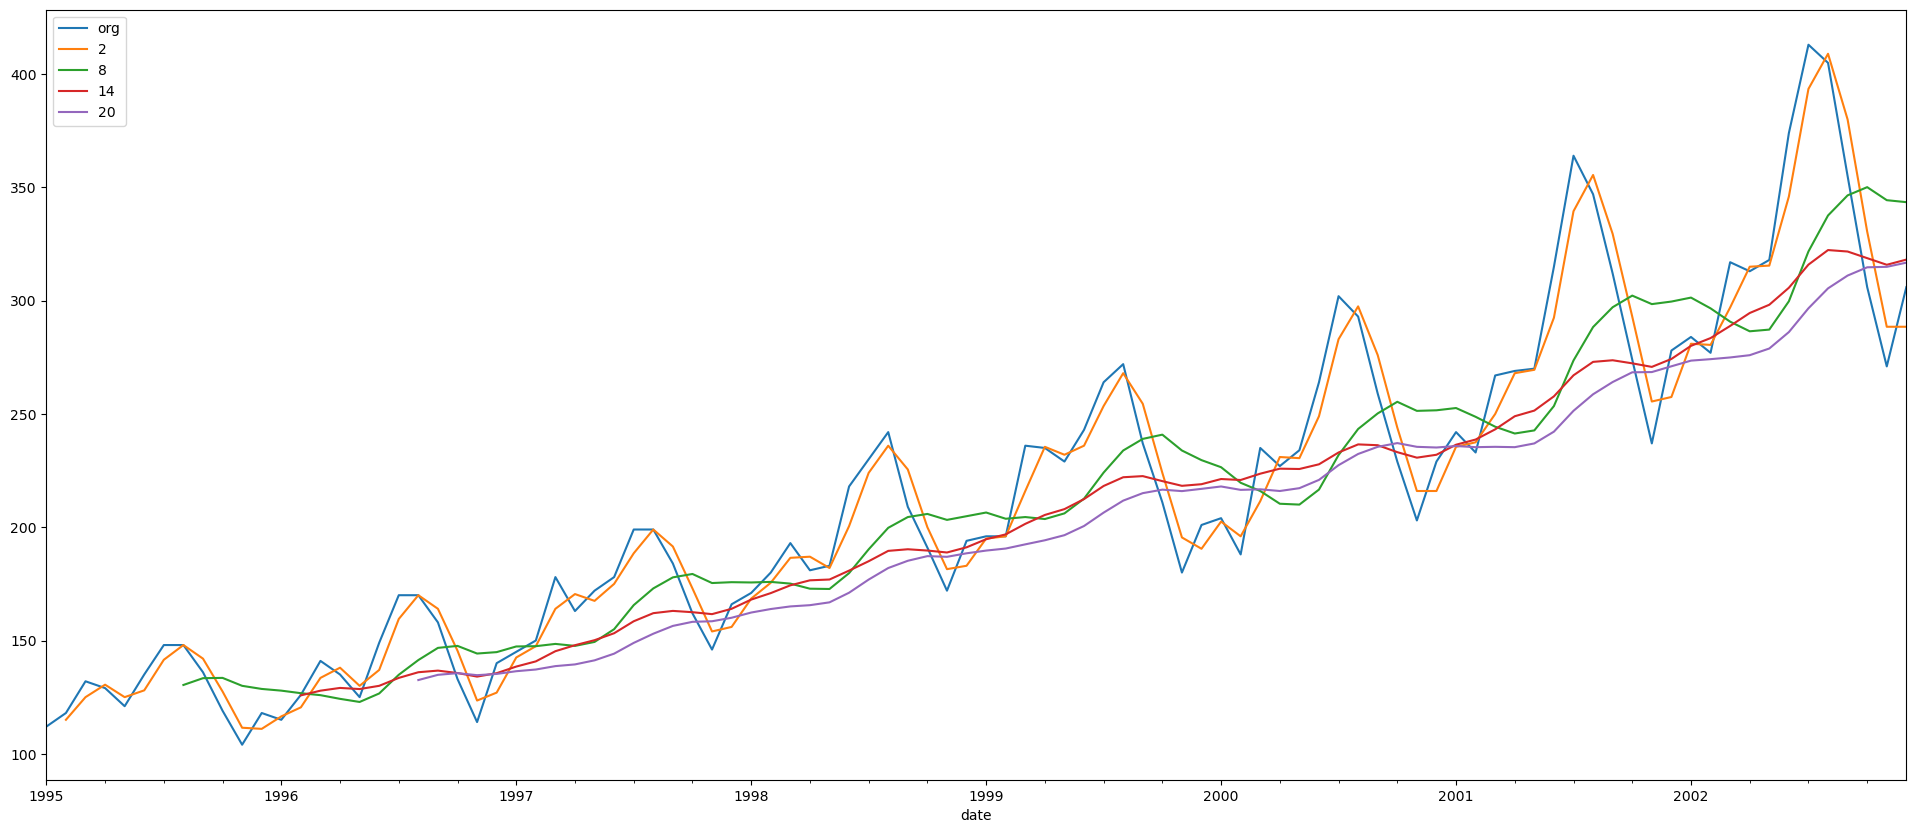

In [20]:
plt.figure(figsize=(24,10))
airlines_upsp.passengers.plot(label="org")
for i in range(2,24,6):
    airlines_upsp['passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

#  Time series decomposition plot

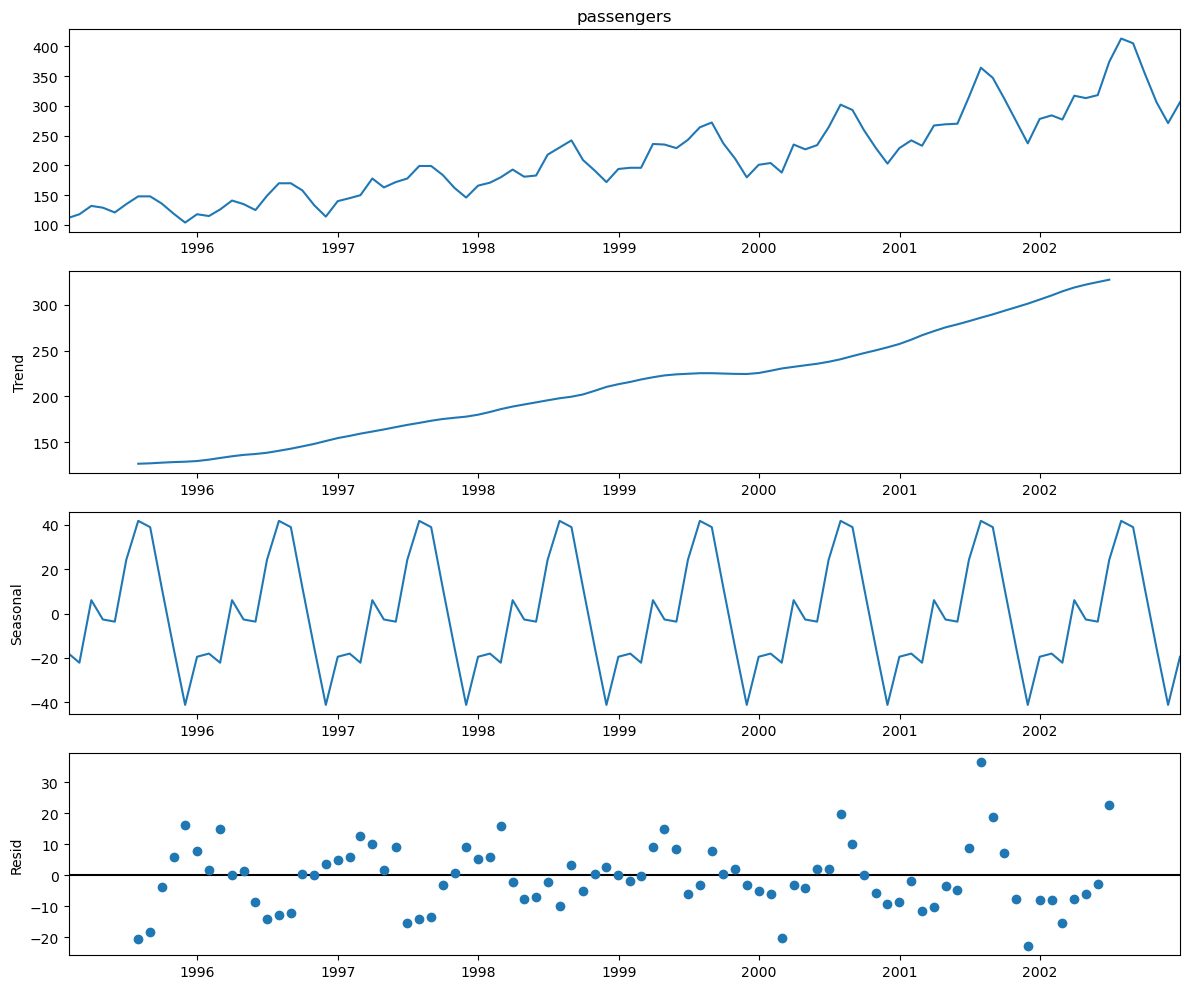

In [21]:
# Time series decomposition plot
decompose_ts_add = seasonal_decompose(airlines_upsp.passengers,period= 12)
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

# ACF plots and PACF plots

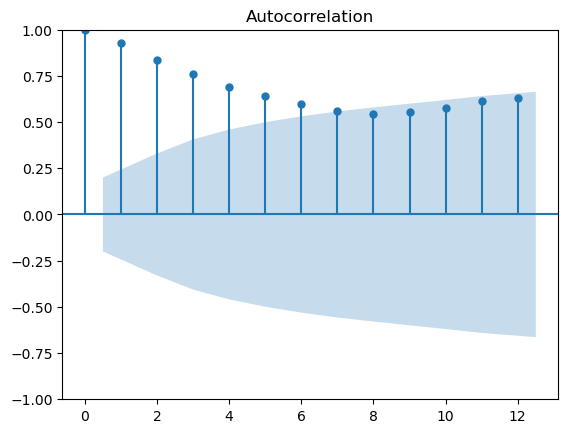

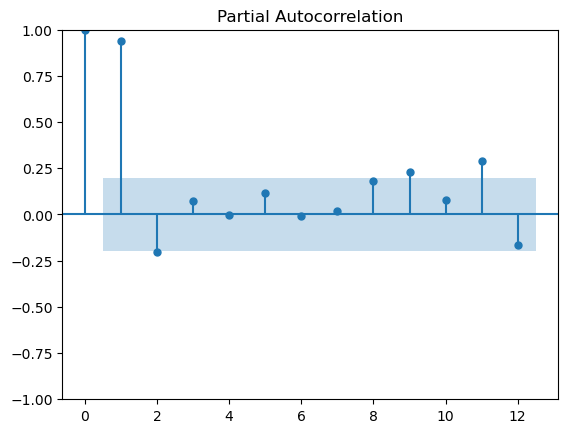

In [22]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(airlines_upsp.passengers,lags=12)
tsa_plots.plot_pacf(airlines_upsp.passengers,lags=12)
plt.show()

# Splitting data

In [23]:
Train=airlines_upsp.head(84)
Test=airlines_upsp.tail(12)     

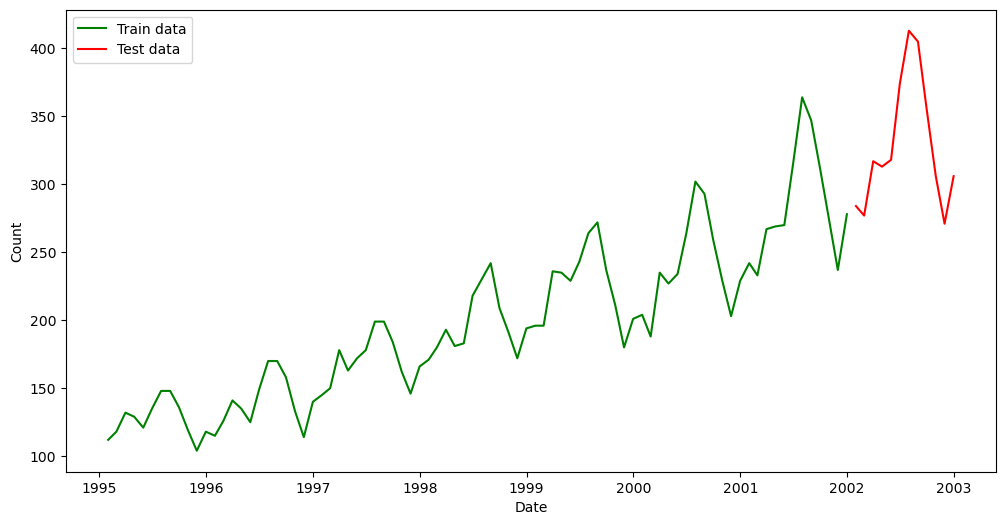

In [24]:
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(Train.passengers, 'green', label='Train data')
plt.plot(Test.passengers, 'red', label='Test data')
plt.legend()
plt.show()

# Evaluation Metric MAPE

In [25]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)
     

# Simple Exponential Method

In [26]:

ses_model = SimpleExpSmoothing(Train['passengers']).fit(optimized=True)
test_pred_ses = ses_model.forecast(12)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = np.sqrt(mean_squared_error(test_pred_ses,Test.passengers))
train_rmse_ses = np.sqrt(mean_squared_error(train_pred_ses,Train.passengers))
mape_ses = MAPE(test_pred_ses,Test.passengers)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ses),"\n",
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ses))
     

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 14.23543315462988 
 Train Root Mean Squared Error = 21.247969155480654 
 Test Root Mean Squared Error  = 68.00674031350329


C:\Users\SANJAY\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


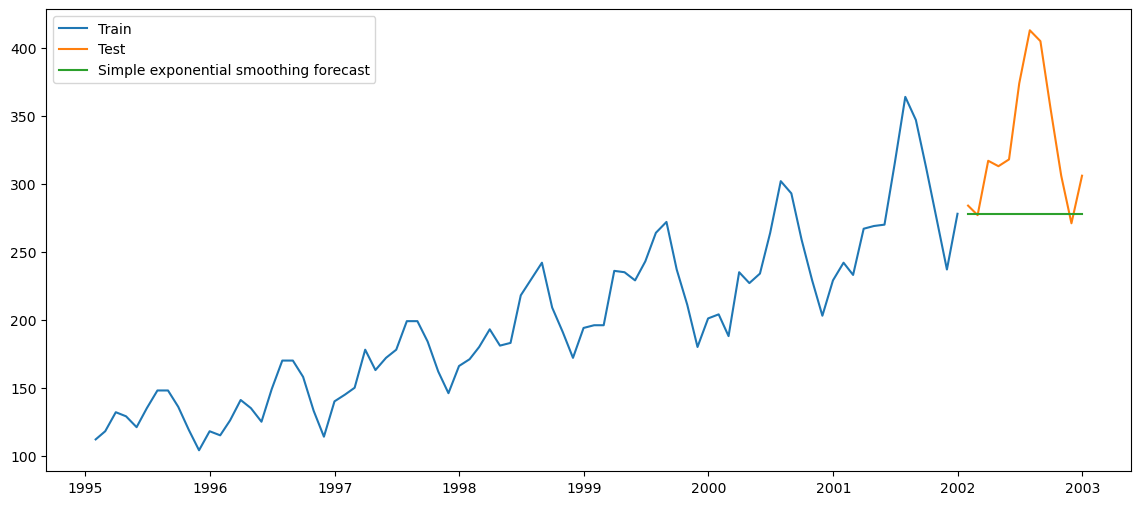

In [27]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.show()
     

# Holt method

In [28]:
hw_model  = Holt(Train["passengers"]).fit(optimized=True)
test_pred_hw = hw_model.forecast(12)
train_pred_hw = hw_model.fittedvalues
test_rmse_hw = np.sqrt(mean_squared_error(test_pred_hw,Test.passengers))
train_rmse_hw = np.sqrt(mean_squared_error(train_pred_hw,Train.passengers))
mape_hw = MAPE(test_rmse_hw,Test.passengers)

print('Holt Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hw),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hw),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hw))


Holt Method Evaluation 
 Mean Absolute Percent Error   = 81.8298995721067 
 Train Root Mean Squared Error = 21.154759039026768 
 Test Root Mean Squared Error  = 58.56209934996357


C:\Users\SANJAY\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


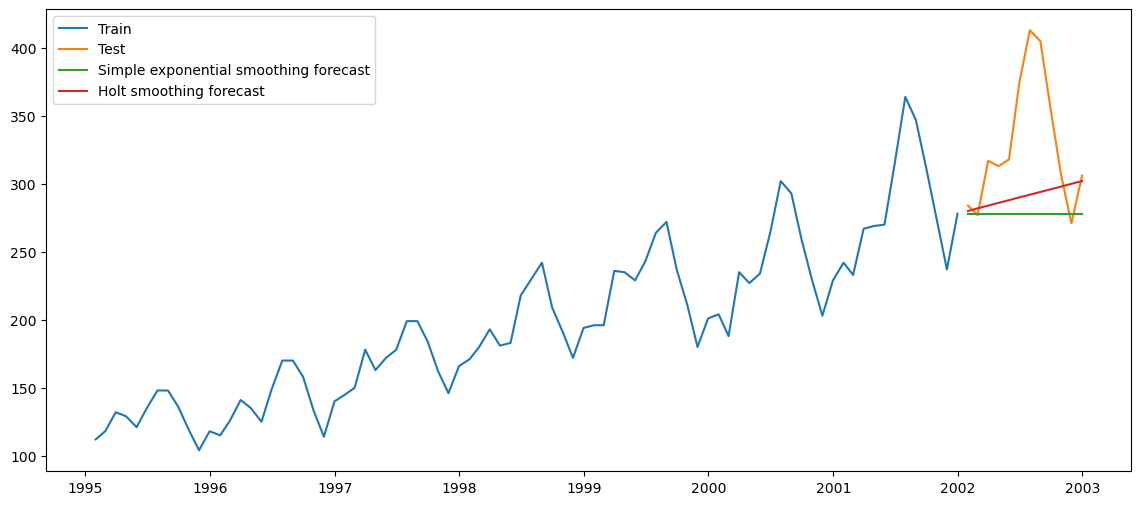

In [29]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.legend(loc='best')
plt.show()

# Holts winter exponential smoothing with additive seasonality and additive trend

In [30]:
holts_add_model  = ExponentialSmoothing(Train.passengers,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_hltadd = holts_add_model.forecast(12)
train_pred_hltadd= holts_add_model.fittedvalues
test_rmse_hltadd = np.sqrt(mean_squared_error(test_pred_hltadd,Test.passengers))
train_rmse_hltadd = np.sqrt(mean_squared_error(train_pred_hltadd,Train.passengers))
mape_hltadd = MAPE(test_pred_hltadd,Test.passengers)

print('Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltadd),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltadd),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltadd))

Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 5.730867880405072 
 Train Root Mean Squared Error = 9.207293821421517 
 Test Root Mean Squared Error  = 29.592574589849935


C:\Users\SANJAY\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


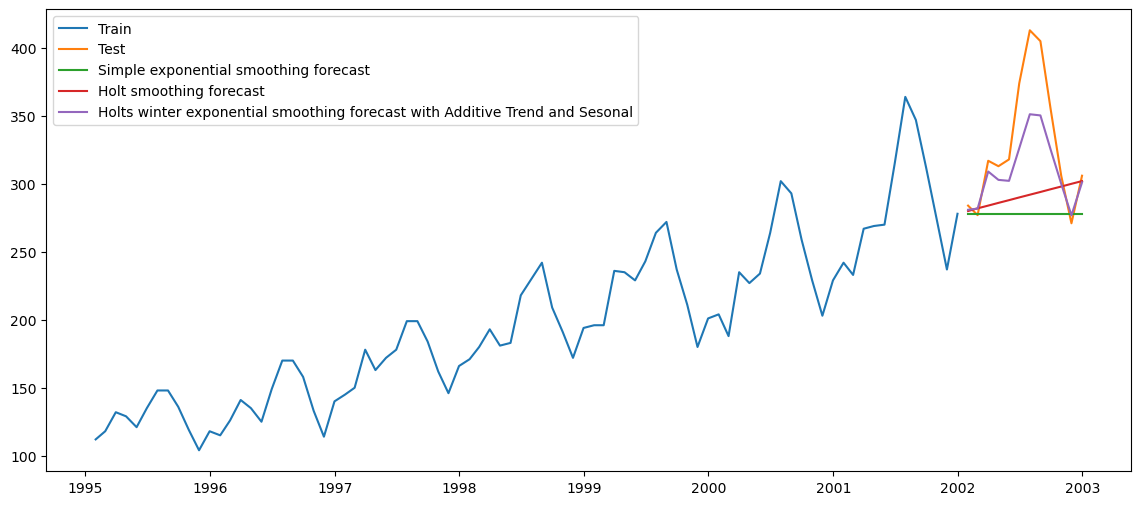

In [31]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

# Holts winter exponential smoothing with add seasonality and multipicative trend

In [32]:
holts_addmul_model  = ExponentialSmoothing(Train.passengers,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_hltaddmul = holts_addmul_model.forecast(12)
train_pred_hltaddmul= holts_addmul_model.fittedvalues
test_rmse_hltaddmul = np.sqrt(mean_squared_error(test_pred_hltaddmul,Test.passengers))
train_rmse_hltaddmul = np.sqrt(mean_squared_error(train_pred_hltaddmul,Train.passengers))
mape_hltaddmul = MAPE(test_pred_hltaddmul,Test.passengers)

print('Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltaddmul),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltaddmul),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltaddmul))
     

Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 2.332974178371654 
 Train Root Mean Squared Error = 12.68376968321976 
 Test Root Mean Squared Error  = 11.30587513922892


C:\Users\SANJAY\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


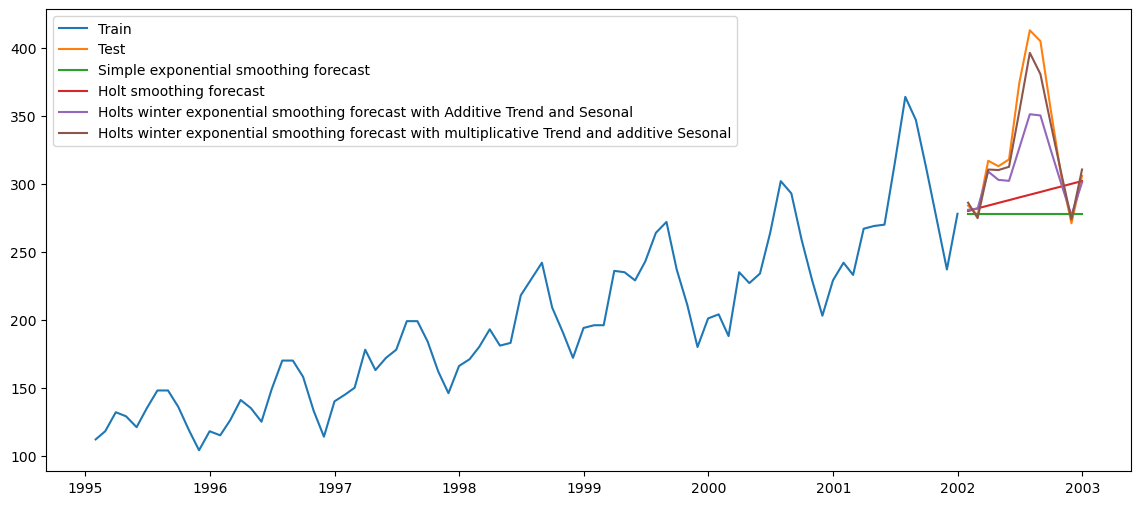

In [33]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.plot(test_pred_hltaddmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and additive Sesonal')
plt.legend(loc='best')
plt.show()
     

# Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [34]:
holts_muladd_model  = ExponentialSmoothing(Train.passengers,seasonal="mul",trend="add",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_hltmuladd = holts_muladd_model.forecast(12)
train_pred_hltmuladd= holts_muladd_model.fittedvalues
test_rmse_hltmuladd = np.sqrt(mean_squared_error(test_pred_hltmuladd,Test.passengers))
train_rmse_hltmuladd = np.sqrt(mean_squared_error(train_pred_hltmuladd,Train.passengers))
mape_hltmuladd = MAPE(test_pred_hltmuladd,Test.passengers)
print('Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltmuladd),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltmuladd),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltmuladd))

Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 6.814461472793396 
 Train Root Mean Squared Error = 9.81792933373369 
 Test Root Mean Squared Error  = 23.371064489838176


C:\Users\SANJAY\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


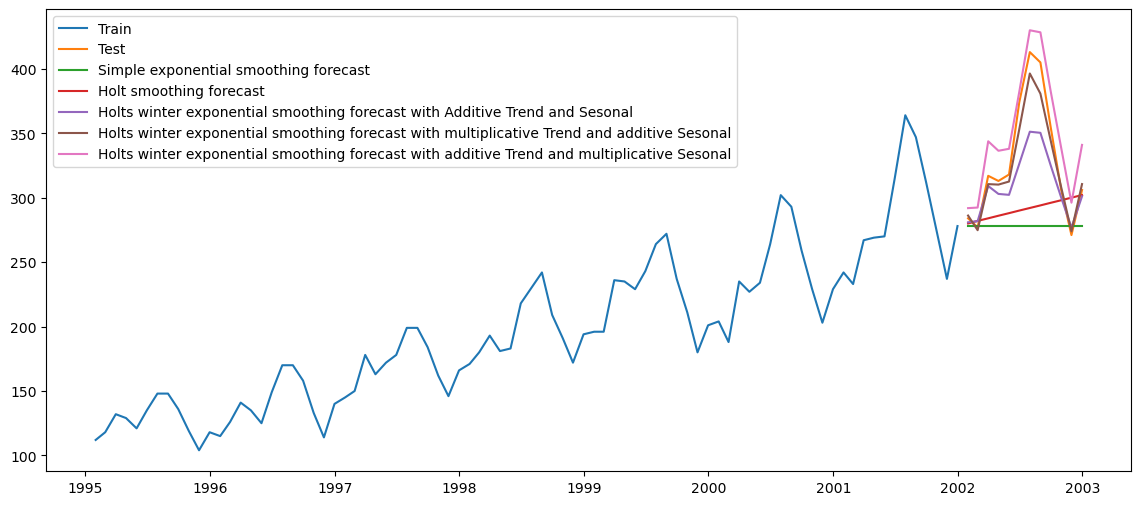

In [35]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.plot(test_pred_hltaddmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and additive Sesonal')
plt.plot(test_pred_hltmuladd, label='Holts winter exponential smoothing forecast with additive Trend and multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

# Holts winter exponential smoothing with multiplicative seasonality and multipicative trend

In [36]:
holts_mul_model  = ExponentialSmoothing(Train.passengers,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_hltmul = holts_mul_model.forecast(12)
train_pred_hltmul= holts_mul_model.fittedvalues
test_rmse_hltmul = np.sqrt(mean_squared_error(test_pred_hltmul,Test.passengers))
train_rmse_hltmul = np.sqrt(mean_squared_error(train_pred_hltmul,Train.passengers))
mape_hltmul = MAPE(test_pred_hltmul,Test.passengers)

print('Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltmul),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltmul),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltmul))
     

Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 1.939883269835697 
 Train Root Mean Squared Error = 6.802696790045708 
 Test Root Mean Squared Error  = 7.757588557262269


C:\Users\SANJAY\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


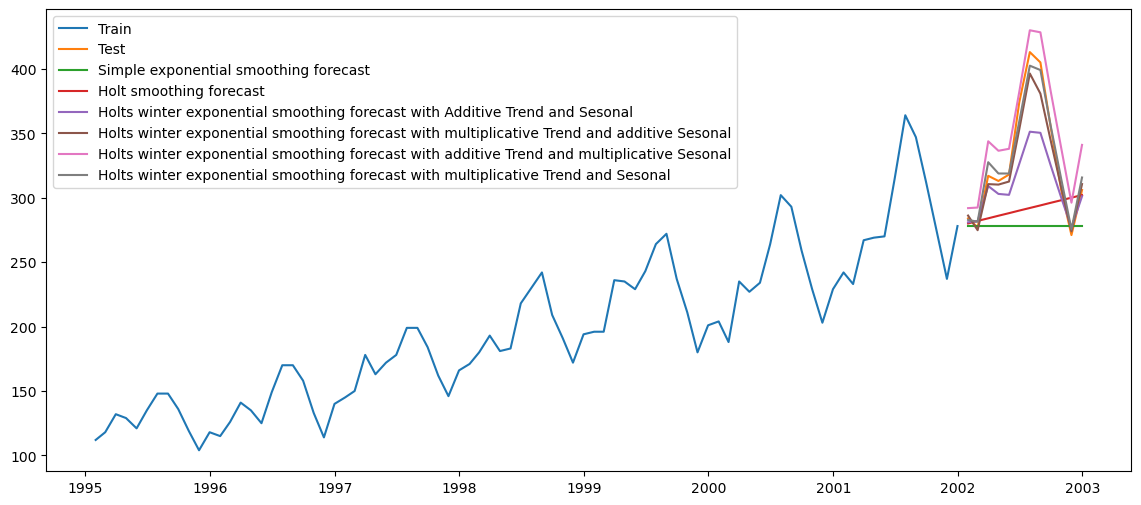

In [37]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.plot(test_pred_hltaddmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and additive Sesonal')
plt.plot(test_pred_hltmuladd, label='Holts winter exponential smoothing forecast with additive Trend and multiplicative Sesonal')
plt.plot(test_pred_hltmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and Sesonal')
plt.legend(loc='best')
plt.show()

# All Models results df

In [38]:
all_mw = {"Models":pd.Series(["Simple_Exp","holts_exp","Holts_Exp_Add","Holts_exp_addmul","Holts_exp_muladd","Holts_Exp_Mul"]),
        "Test_MAPE(%)":pd.Series(np.round([mape_ses,mape_hw,mape_hltadd,mape_hltaddmul,mape_hltmuladd,mape_hltmul],2)),
        "Train_RMSE":pd.Series(np.round([train_rmse_ses,train_rmse_hw,train_rmse_hltadd,train_rmse_hltaddmul,train_rmse_hltaddmul,train_rmse_hltmul],2)),
        "Test_RMSE_Values":pd.Series(np.round([test_rmse_ses,test_rmse_hw,test_rmse_hltadd,test_rmse_hltaddmul,test_rmse_hltmuladd,test_rmse_hltmul],2))}
table_allmw=pd.DataFrame(all_mw)
table_allmw.sort_values(['Test_RMSE_Values'], inplace=True, ignore_index=True)
table_allmw

,Models,Test_MAPE(%),Train_RMSE,Test_RMSE_Values
0,Holts_Exp_Mul,1.94,6.80,7.76
1,Holts_exp_addmul,2.33,12.68,11.31
2,Holts_exp_muladd,6.81,12.68,23.37
3,Holts_Exp_Add,5.73,9.21,29.59
4,holts_exp,81.83,21.15,58.56
5,Simple_Exp,14.24,21.25,68.01


# Final Model by combining train and test

In [39]:
hwe_model_mul = ExponentialSmoothing(Train.passengers,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)

C:\Users\SANJAY\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [40]:
#Forecasting for next 12 time periods
hwe_model_mul.forecast(12)     

2002-01-31    282.794997
2002-02-28    281.344764
2002-03-31    327.550877
2002-04-30    318.798902
2002-05-31    318.781617
                 ...    
2002-08-31    399.068141
2002-09-30    355.994159
2002-10-31    314.509607
2002-11-30    275.386208
2002-12-31    315.690816
Freq: M, Length: 12, dtype: float64

# Forecasting_Model_based_methods

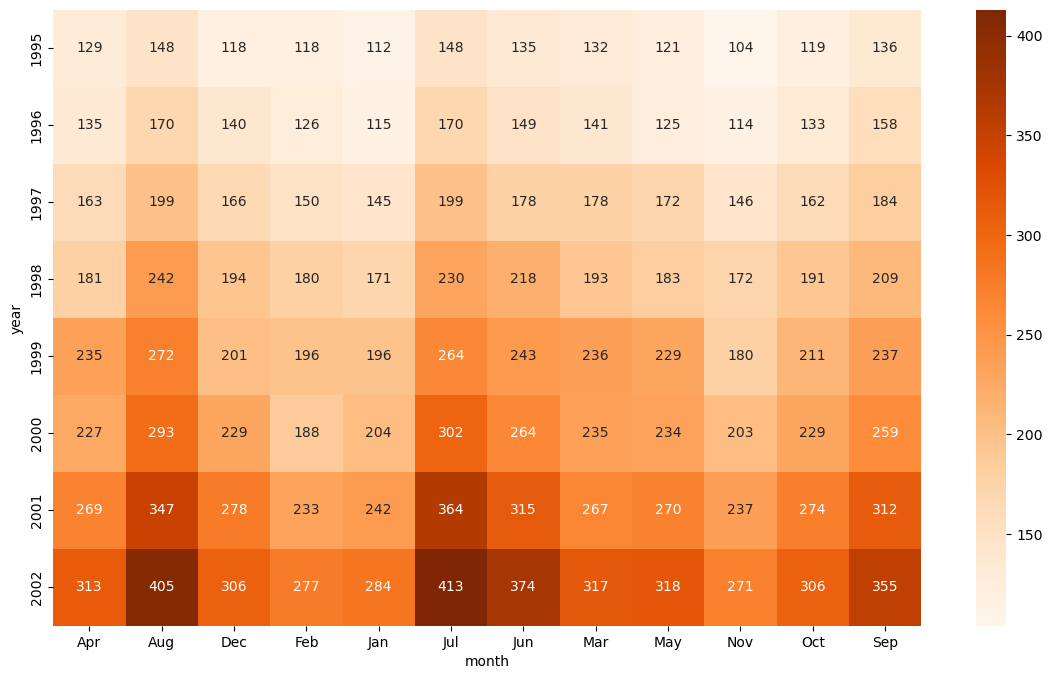

In [41]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=airlines_upsp,values="passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g",cmap='Oranges')
plt.show()

<AxesSubplot:xlabel='year', ylabel='passengers'>

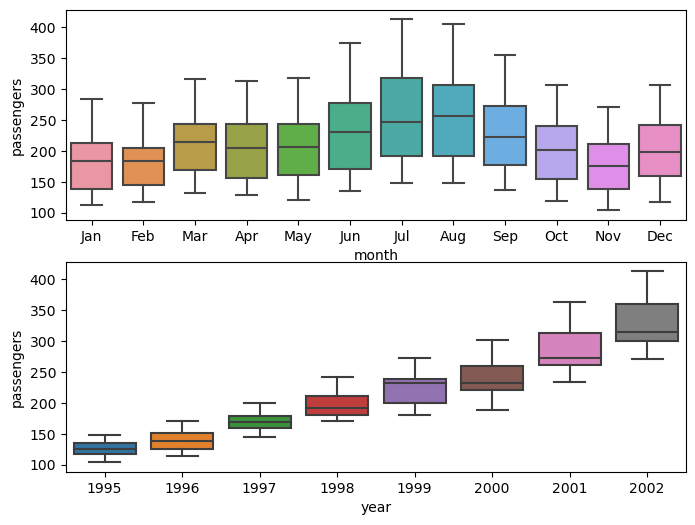

In [42]:
# box plot for ever
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x='month',y='passengers',data=airlines_upsp)
plt.subplot(212)
sns.boxplot(x='year',y='passengers',data=airlines_upsp)

In [43]:
Train=airlines_upsp.head(84)
Test=airlines_upsp.tail(12)
Test

,passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
date,,,,,,,,,,,,,,,,,,
2002-01-31,284.0,85,7225,Jan,2002,1,0,0,0,0,0,0,0,0,0,0,0,5.648974
2002-02-28,277.0,86,7396,Feb,2002,0,1,0,0,0,0,0,0,0,0,0,0,5.624018
2002-03-31,317.0,87,7569,Mar,2002,0,0,1,0,0,0,0,0,0,0,0,0,5.758902
2002-04-30,313.0,88,7744,Apr,2002,0,0,0,1,0,0,0,0,0,0,0,0,5.746203
2002-05-31,318.0,89,7921,May,2002,0,0,0,0,1,0,0,0,0,0,0,0,5.762051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-08-31,405.0,92,8464,Aug,2002,0,0,0,0,0,0,0,1,0,0,0,0,6.003887
2002-09-30,355.0,93,8649,Sep,2002,0,0,0,0,0,0,0,0,1,0,0,0,5.872118
2002-10-31,306.0,94,8836,Oct,2002,0,0,0,0,0,0,0,0,0,1,0,0,5.723585


# Linear model

In [44]:

linear_model=smf.ols('passengers~t',data=Train).fit()
pred_linear=pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rsme_linear=np.sqrt(np.mean((np.array(Test['passengers'])-np.array(pred_linear))**2))
rsme_linear

53.19923653480267

# Exponential Model

In [45]:
Exp = smf.ols('log_passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

46.05736110315608

# Quadratic Model

In [46]:
Quad = smf.ols('passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['passengers'])-np.array(pred_Quad))**2))
rmse_Quad

48.05188897933096

# Compare the results

In [47]:
data = {"MODEL":pd.Series(["RMSE_Linear","RMSE_Exp","RMSE_Quad"]),
        "RMSE_Values":pd.Series(np.round([rsme_linear,rmse_Exp,rmse_Quad],2))}
table_rmse=pd.DataFrame(data)
table_rmse

,MODEL,RMSE_Values
0,RMSE_Linear,53.20
1,RMSE_Exp,46.06
2,RMSE_Quad,48.05


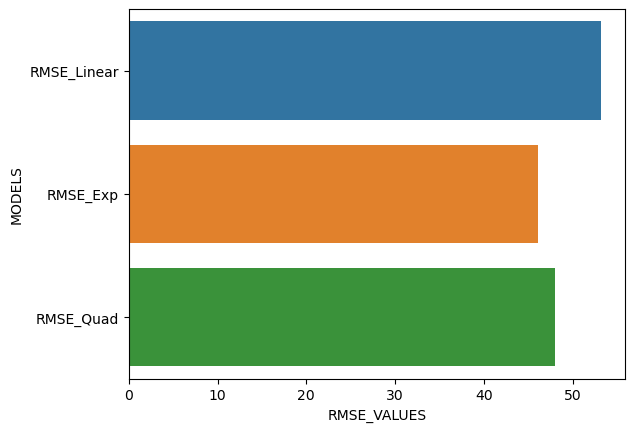

In [48]:
# Plotting the RMSE results
sns.barplot(x='RMSE_Values',y='MODEL',data=table_rmse)
plt.xlabel('RMSE_VALUES')
plt.ylabel('MODELS')
plt.show()

# ARIMA Hyperparameters

In [49]:
# Split the data
Train=airlines_upsp.head(84)
Test=airlines_upsp.tail(12)

In [50]:
# walk-forward validation
history = [x for x in Train.passengers]
predictions = []
for i in range(len(Test.passengers)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = Test.passengers[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = np.sqrt(mean_squared_error(Test.passengers, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=278.000, Expected=284.000
>Predicted=284.000, Expected=277.000
>Predicted=277.000, Expected=317.000
>Predicted=317.000, Expected=313.000
>Predicted=313.000, Expected=318.000
>Predicted=318.000, Expected=374.000
>Predicted=374.000, Expected=413.000
>Predicted=413.000, Expected=405.000
>Predicted=405.000, Expected=355.000
>Predicted=355.000, Expected=306.000
>Predicted=306.000, Expected=271.000
>Predicted=271.000, Expected=306.000
RMSE: 33.909


In [51]:
# Build Model

model = ARIMA(Train.passengers, order=(3, 2, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc= fitted.forecast(12,alpha=0.05)  # 95% conf



                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                   84
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -365.272
Date:                Wed, 15 Mar 2023   AIC                            740.545
Time:                        19:15:27   BIC                            752.578
Sample:                    01-31-1995   HQIC                           745.376
                         - 12-31-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2491      0.129      1.927      0.054      -0.004       0.502
ar.L2         -0.1924      0.136     -1.414      0.157      -0.459       0.074
ar.L3         -0.1285      0.115     -1.117      0.2

C:\Users\SANJAY\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\SANJAY\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\SANJAY\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


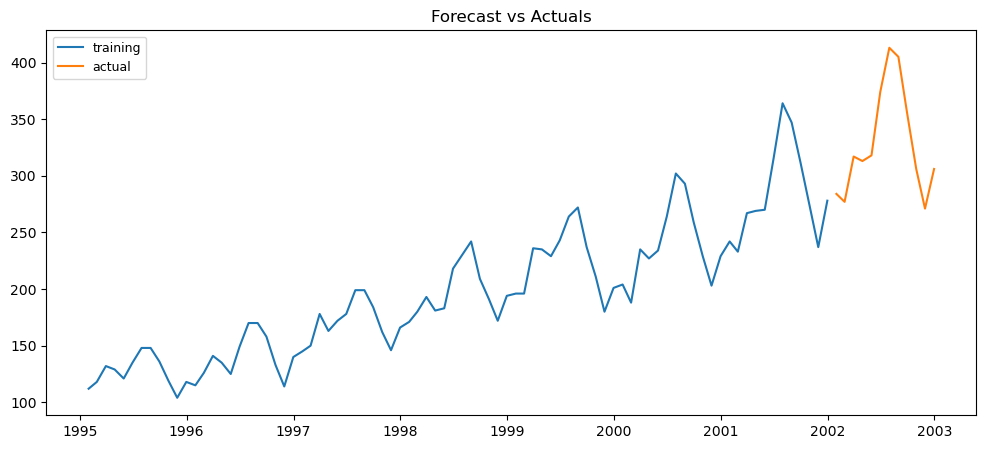

In [52]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(Train.passengers, label='training')
plt.plot(Test.passengers, label='actual')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=9)
plt.show()

In [53]:
Arima_rmse = np.mean((fc - Test.passengers)**2)**.5
print("ARIMA_RMSE_VALUES:" ,Arima_rmse)
     

ARIMA_RMSE_VALUES: 51.03103633267609


# Conclusion:

In [54]:
all_rsme={"MODEL":pd.Series(["Simple_Exp","holts_exp","Holts_Exp_Add","Holts_exp_addmul","Holts_exp_muladd","Holts_Exp_Mul","rmse_linear",
                             "rmse_Exp","rmse_Quad","ARIMA"]),
        "RMSE_Values":pd.Series(np.round([train_rmse_ses,train_rmse_hw,train_rmse_hltadd,train_rmse_hltaddmul,train_rmse_hltaddmul,train_rmse_hltmul,
                                          rsme_linear,rmse_Exp,rmse_Quad,Arima_rmse],2))}
tab_rmse=pd.DataFrame(all_rsme)
tab_rmse=tab_rmse.sort_values(['RMSE_Values'])
tab_rmse

,MODEL,RMSE_Values
5,Holts_Exp_Mul,6.80
2,Holts_Exp_Add,9.21
3,Holts_exp_addmul,12.68
4,Holts_exp_muladd,12.68
1,holts_exp,21.15
0,Simple_Exp,21.25
7,rmse_Exp,46.06
8,rmse_Quad,48.05
9,ARIMA,51.03
6,rmse_linear,53.20


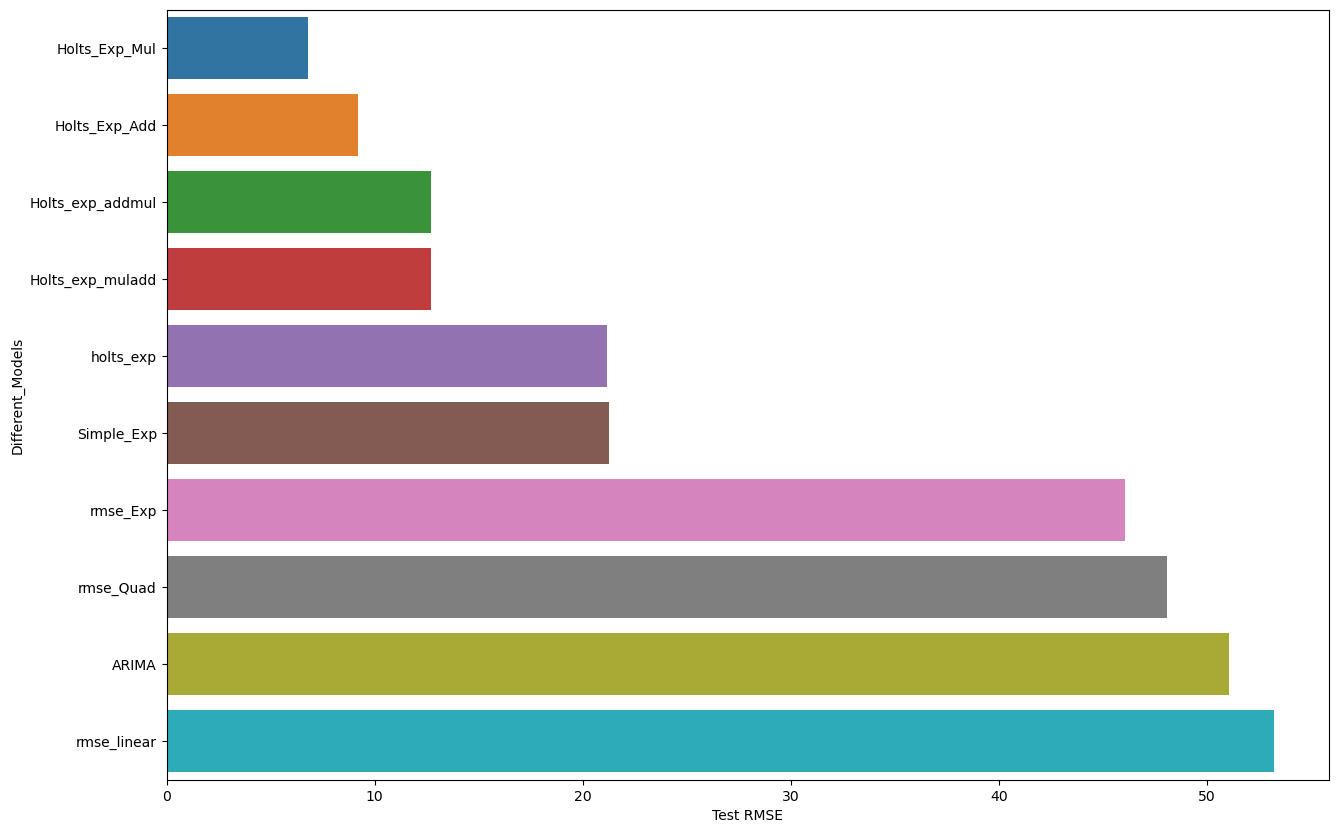

In [55]:
# Plotting Results
plt.figure(figsize=(15,10))
sns.barplot(x='RMSE_Values', y='MODEL', data=tab_rmse)
plt.xlabel('Test RMSE')
plt.ylabel('Different_Models')
plt.show()